# Fine-tune and evaluate a candy detection model

See the tutorial [**Training Custom Object Detector**](https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/training.html) for more information and troubleshooting.

## 0. Upload scripts and set up Paths

First you need to upload the helper scripts `config.py` and `generate_tfrecord.py`. The former will make it easier to set up and keep track of the various paths and the latter converts images and annotations into a data format useful for training tensorflow models, `tfrecords`.

Upload `config.py` to the default Colab directory (`/content`).

Once that is done, run `config.py`:

In [1]:
%run config.py

By clicking **Files**, you should see the directory structure created.

Upload `generate_tfrecord.py` to `Tensorflow/scripts`

## 1. Download TF Models Pretrained Models from Tensorflow Model Zoo and Install TFOD

In [2]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
  !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

Cloning into 'Tensorflow/models'...
remote: Enumerating objects: 75161, done.
remote: Total 75161 (delta 0), reused 0 (delta 0), pack-reused 75161
Receiving objects: 100% (75161/75161), 580.39 MiB | 39.12 MiB/s, done.
Resolving deltas: 100% (53341/53341), done.


In [3]:
# Install Tensorflow Object Detection (TFOD)
!apt-get install protobuf-compiler
!cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 62 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/Tensorflow/models/research
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 10.9 MB 40.3 MB/s 
     |██████████████████████████████

Fix some other installation/version issues.

In [4]:
!pip install tensorflow --upgrade
!pip uninstall protobuf matplotlib -y
!pip install protobuf==3.19 matplotlib==3.2
!pip install -U opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Found existing installation: protobuf 3.19.4
Uninstalling protobuf-3.19.4:
  Successfully uninstalled protobuf-3.19.4
Found existing installation: matplotlib 3.2.2
Uninstalling matplotlib-3.2.2:
  Successfully uninstalled matplotlib-3.2.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 25.8 MB/s 
     |████████████████████████████████| 12.4 MB 45.8 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 60.9 MB 171 kB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [5]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8
1 upgraded, 0 newly installed, 1 to remove and 60 not upgraded.
Need to get 430 MB of archives.
After this operation, 3,139 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 7s (62.9 MB/s)
(Reading database ... 155639 files and directories currently installed.)
Removing libcudnn8-dev (8.0.5.39-1+cuda11.1) ...
(Reading database ... 155617 files and directories currently installed.)
Preparing to unpack .../libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb ...
Unpacking libcudnn8 (8.1.0.77-1+c

Run the verification script to check that the installation is ok.

In [6]:
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# Verify Installation
!python {VERIFICATION_SCRIPT}

Running tests under Python 3.7.13: /usr/bin/python3
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_deepmac
2022-07-08 19:18:01.555917: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
W0708 19:18:01.779951 140267407386496 model_builder.py:1102] Building experimental DeepMAC meta-arch. Some features may be omitted.
INFO:tensorflow:time(__main__.ModelBuilderTF2Test.test_create_center_net_deepmac): 1.49s
I0708 19:18:02.163463 140267407386496 test_util.py:2459] time(__main__.ModelBuilderTF2Test.test_create_center_net_deepmac): 1.49s
[       OK ] ModelBuilderTF2Test.test_create_center_net_deepmac
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_model0 (customize_head_params=True)
INFO:tensorflow:time(__main__.ModelBuilderTF2Test.test_create_center_net_model0 (customize_head_params=True)): 0.51s
I0708 19:18:02.670647 140267407386496 test_u

Restart runtime and re-run `config.py`.

In [15]:
# Re-run config.py after restarting the runtime.
%run config.py
import object_detection

Download the pretrained object detection model.

In [8]:
!wget {PRETRAINED_MODEL_URL}
!mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
!cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

--2022-07-08 19:18:34--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.9.208, 2607:f8b0:4004:837::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.9.208|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20515344 (20M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’

ssd_mobilenet_v2_fp 100%[===================>]  19.56M  --.-KB/s    in 0.08s   

2022-07-08 19:18:34 (241 MB/s) - ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’ saved [20515344/20515344]

ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/checkpoint
ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8

## 2. Upload the label map, images and annotations.

Upload `label_map.pbtxt` to `Tensorflow/workspace/annotations`.

In [9]:
from google.colab import files

uploaded = files.upload()

Upload the exported images and annotations ZIP files (`train.zip` and `test.zip`) to the default directory (`/content`).

In [10]:
from google.colab import files

uploaded = files.upload()

Saving test.zip to test (1).zip
Saving train.zip to train (1).zip


Unzip the uploaded `train.zip` and `text.zip`.

In [10]:
!unzip 'train.zip' -d '/content/Tensorflow/workspace/images'
!unzip 'test.zip' -d '/content/Tensorflow/workspace/images'

Archive:  train.zip
   creating: /content/Tensorflow/workspace/images/train/
   creating: /content/Tensorflow/workspace/images/train/Annotations/
  inflating: /content/Tensorflow/workspace/images/train/Annotations/099f8fc2-cd_32.xml  
  inflating: /content/Tensorflow/workspace/images/train/Annotations/0dead746-cd_08.xml  
  inflating: /content/Tensorflow/workspace/images/train/Annotations/2ba4252f-cd_24.xml  
  inflating: /content/Tensorflow/workspace/images/train/Annotations/66eeee46-cd_34.xml  
  inflating: /content/Tensorflow/workspace/images/train/Annotations/7456c9fd-cd_04.xml  
  inflating: /content/Tensorflow/workspace/images/train/Annotations/a6ea9237-cd_07.xml  
  inflating: /content/Tensorflow/workspace/images/train/Annotations/b604a9b2-cd_23.xml  
  inflating: /content/Tensorflow/workspace/images/train/Annotations/ba5fa5e8-cd_09.xml  
   creating: /content/Tensorflow/workspace/images/train/images/
  inflating: /content/Tensorflow/workspace/images/train/images/099f8fc2-cd_32.

## 3. Create TF records

Check the printed outupt and verify that the created `tfrecord` files both have more than 0 examples.

In [11]:
!python 'Tensorflow/scripts/generate_tfrecord.py' -x 'Tensorflow/workspace/images/train/Annotations' -i 'Tensorflow/workspace/images/train/images' -l 'Tensorflow/workspace/annotations/label_map.pbtxt' -o 'Tensorflow/workspace/annotations/train.record'
!python 'Tensorflow/scripts/generate_tfrecord.py' -x 'Tensorflow/workspace/images/test/Annotations' -i 'Tensorflow/workspace/images/test/images' -l 'Tensorflow/workspace/annotations/label_map.pbtxt' -o 'Tensorflow/workspace/annotations/test.record'

Successfully created the TFRecord file: Tensorflow/workspace/annotations/train.record with 138 examples
Successfully created the TFRecord file: Tensorflow/workspace/annotations/test.record with 49 examples


## 4. Copy Model Config to Training Folder

In [12]:
!cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

## 5. Update Config For Transfer Learning

In [13]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [16]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

In [17]:
config

{'eval_config': metrics_set: "coco_detection_metrics"
 use_moving_averages: false,
 'eval_input_config': label_map_path: "PATH_TO_BE_CONFIGURED"
 shuffle: false
 num_epochs: 1
 tf_record_input_reader {
   input_path: "PATH_TO_BE_CONFIGURED"
 },
 'eval_input_configs': [label_map_path: "PATH_TO_BE_CONFIGURED"
 shuffle: false
 num_epochs: 1
 tf_record_input_reader {
   input_path: "PATH_TO_BE_CONFIGURED"
 }
 ],
 'model': ssd {
   num_classes: 90
   image_resizer {
     fixed_shape_resizer {
       height: 320
       width: 320
     }
   }
   feature_extractor {
     type: "ssd_mobilenet_v2_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 3.9999998989515007e-05
         }
       }
       initializer {
         random_normal_initializer {
           mean: 0.0
           stddev: 0.009999999776482582
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.9969999790191

In [18]:
from google.protobuf import text_format as pbtfimport

labelmap_path = os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)

def read_label_map(label_map_path):

    item_id = None
    item_name = None
    items = {}
    
    with open(label_map_path, "r") as file:
        for line in file:
            line.replace(" ", "")
            if line == "item{":
                pass
            elif line == "}":
                pass
            elif "id" in line:
                item_id = int(line.split(":", 1)[1].strip())
            elif "name" in line:
                item_name = line.split(":", 1)[1].replace("'", "").strip()

            if item_id is not None and item_name is not None:
                items[item_name] = item_id
                item_id = None
                item_name = None

    return items

labels = read_label_map(labelmap_path)    

In [19]:
print(labels)

{'Moon': 1, 'Insect': 2, 'Black_star': 3, 'Grey_star': 4, 'Unicorn_whole': 5, 'Unicorn_head': 6, 'Owl': 7, 'Cat': 8}


In [20]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [21]:
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

In [22]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

## 6. Train the model

In [23]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

In [24]:
command = "python {} --model_dir={} --alsologtostderr --pipeline_config_path={} --num_train_steps=2000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])

In [25]:
print(command)

python Tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=Tensorflow/workspace/models/my_ssd_mobnet --alsologtostderr --pipeline_config_path=Tensorflow/workspace/models/my_ssd_mobnet/pipeline.config --num_train_steps=2000


In [26]:
!{command}

2022-07-08 19:22:36.442494: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
I0708 19:22:36.447877 140697282021248 mirrored_strategy.py:374] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Maybe overwriting train_steps: 2000
I0708 19:22:36.451755 140697282021248 config_util.py:552] Maybe overwriting train_steps: 2000
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0708 19:22:36.451919 140697282021248 config_util.py:552] Maybe overwriting use_bfloat16: False
Instructions for updating:
rename to distribute_datasets_from_function
W0708 19:22:36.593614 140697282021248 deprecation.py:356] From /usr/local/lib/python3.7/dist-packages/object_detection/model_lib_v2.py:564: StrategyBase.experimental

## 7. Evaluate the Model

In [27]:
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'])

In [28]:
print(command)

python Tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=Tensorflow/workspace/models/my_ssd_mobnet --pipeline_config_path=Tensorflow/workspace/models/my_ssd_mobnet/pipeline.config --checkpoint_dir=Tensorflow/workspace/models/my_ssd_mobnet


In [29]:
!{command}

W0708 19:28:56.728762 140468216985472 model_lib_v2.py:1090] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: None
I0708 19:28:56.728996 140468216985472 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: None
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0708 19:28:56.729084 140468216985472 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0708 19:28:56.729168 140468216985472 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W0708 19:28:56.729279 140468216985472 model_lib_v2.py:1110] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
2022-07-08 19:28:57.558273: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config 

# 8. Load a trained model from a checkpoint

In [30]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [31]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-3')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# 9. Detect from an Image

In [32]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [33]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

Change the `image_path` to fit an image in the test set.

In [34]:
image_path = '/content/Tensorflow/workspace/images/test/images/f691fbdc-cd_35.jpg'
# image_path = '/content/Tensorflow/workspace/images/test/images/bbe859af-cd_21.jpg'

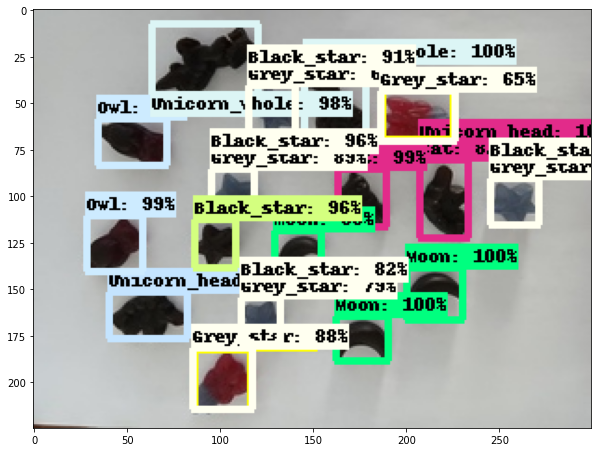

In [35]:
img = cv2.imread(image_path)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=30,
            min_score_thresh=.6,
            agnostic_mode=False)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
ax.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

# 10. Freezing the Graph

In [36]:
FREEZE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'exporter_main_v2.py ')

In [37]:
command = "python {} --input_type=image_tensor --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(FREEZE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['OUTPUT_PATH'])

In [38]:
print(command)

python Tensorflow/models/research/object_detection/exporter_main_v2.py  --input_type=image_tensor --pipeline_config_path=Tensorflow/workspace/models/my_ssd_mobnet/pipeline.config --trained_checkpoint_dir=Tensorflow/workspace/models/my_ssd_mobnet --output_directory=Tensorflow/workspace/models/my_ssd_mobnet/export


In [39]:
!{command}

2022-07-08 19:37:28.133107: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
W0708 19:37:28.266232 140314904328064 deprecation.py:628] From /usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:458: calling map_fn_v2 (from tensorflow.python.ops.map_fn) with back_prop=False is deprecated and will be removed in a future version.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
W0708 19:37:48.169982 1403149043280

# 12. Conversion to TFLite

In [40]:
TFLITE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'export_tflite_graph_tf2.py ')

In [41]:
command = "python {} --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(TFLITE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['TFLITE_PATH'])

In [42]:
print(command)

python Tensorflow/models/research/object_detection/export_tflite_graph_tf2.py  --pipeline_config_path=Tensorflow/workspace/models/my_ssd_mobnet/pipeline.config --trained_checkpoint_dir=Tensorflow/workspace/models/my_ssd_mobnet --output_directory=Tensorflow/workspace/models/my_ssd_mobnet/tfliteexport


In [43]:
!{command}

2022-07-08 19:40:20.552794: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
W0708 19:40:31.478846 140623691540352 save_impl.py:72] Skipping full serialization of Keras layer <object_detection.meta_architectures.ssd_meta_arch.SSDMetaArch object at 0x7fe4f0676c90>, because it is not built.
W0708 19:40:31.741462 140623691540352 save_impl.py:72] Skipping full serialization of Keras layer <keras.layers.convolutional.separable_conv2d.SeparableConv2D object at 0x7fe4f053dcd0>, because it is not built.
W0708 19:40:31.741690 140623691540352 save_impl.py:72] Skipping full serialization of Keras layer <object_detection.core.freezable_batch_norm.FreezableBatchNorm object at 0x7fe4f063d290>, because it is not built.
W0708 19:40:31.741801 140623691540352 save_impl.py:72] Skipping full serialization of Keras layer <keras.layers.core.lambda_layer.Lambda object at 

In [44]:
FROZEN_TFLITE_PATH = os.path.join(paths['TFLITE_PATH'], 'saved_model')
TFLITE_MODEL = os.path.join(paths['TFLITE_PATH'], 'saved_model', 'detect.tflite')

In [45]:
command = "tflite_convert \
--saved_model_dir={} \
--output_file={} \
--input_shapes=1,300,300,3 \
--input_arrays=normalized_input_image_tensor \
--output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' \
--inference_type=FLOAT \
--allow_custom_ops".format(FROZEN_TFLITE_PATH, TFLITE_MODEL, )

In [46]:
print(command)

tflite_convert --saved_model_dir=Tensorflow/workspace/models/my_ssd_mobnet/tfliteexport/saved_model --output_file=Tensorflow/workspace/models/my_ssd_mobnet/tfliteexport/saved_model/detect.tflite --input_shapes=1,300,300,3 --input_arrays=normalized_input_image_tensor --output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' --inference_type=FLOAT --allow_custom_ops


In [47]:
!{command}

2022-07-08 20:05:52.096379: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-07-08 20:06:01.362555: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-07-08 20:06:01.362624: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
Estimated count of arithmetic ops: 1.727 G  ops, equivalently 0.863 G  MACs


# 13. Zip and Export Models 

In [48]:
!tar -czf models.tar.gz {paths['CHECKPOINT_PATH']}